In [89]:
#CASE: SYSTEM OF TWO GAS WELLS IN A SURFACE NETWORK
#AUTHOR: MILAN STANKO, NTNU, COURSE: TPG4230
#IMPORTING NEEDED LIBRARIES
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [90]:
#FUNCTIONS
def IPRqg(CR, n, pR, pwf):
    a = CR * np.power((np.power(pR, 2) - np.power(pwf,2)),n) 
    return a

def IPRpwf(CR, n, pR, qg):
    a = np.power(((np.power(pR, 2) - np.power((qg / CR), (1 / n)))) , 0.5)
    return a

def Tubingqg(CT, s, p1, p2):
    a = CT * np.power((np.power(p1, 2) / np.exp(s) - np.power(p2, 2)), 0.5)
    return a

def Tubingp1(CT, s, p2, qg):
    a = math.exp(s / 2) * np.power((np.power(p2, 2) + np.power((qg / CT),2)), 0.5)
    return a

def Tubingp2(CT, s, p1, qg):
    a = np.power((np.power(p1, 2) / np.exp(s) - np.power((qg / CT), 2)),0.5)
    return a
#WELLHEAD PERFORMANCE RELATIONSHIP
def WPR_pwh(pR,CR,n,CT,S,qg):
    pwf=IPRpwf(CR, n, pR, qg)
    pwh=Tubingp2(CT,S,pwf,qg)
    return pwh

v_WPR_pwh=np.vectorize(WPR_pwh)

def Lineqg(Cfl, p1, p2):
    a = Cfl * np.power(np.power(p1, 2) - np.power(p2, 2), 0.5)
    return a

def Linep1(Cfl, p2, qg):
    a = np.power((np.power(p2, 2) + np.power((qg / Cfl), 2)),0.5)
    return a

def Linep2(Cfl, p1, qg):
    a = np.power((np.power(p1, 2) - np.power((qg / Cfl), 2)), 0.5)
    return a

v_Linep1=np.vectorize(Linep1)
#REQUIRED PRESSURE AT CHOKE DISCHARGE CALCULATED FROM SEPARATOR FOR ALL WELLS
def pwh_REQ(Cpl,Cfl,psep,qg):
    pj=Linep1(Cpl,psep,np.sum(qg)) 
    pwh=v_Linep1(Cfl,pj,qg)
    return pwh

def error(qg,pR,CR,n,CT,S,Cpl,Cfl,psep,DP):
    pavail=v_WPR_pwh(pR,CR,n,CT,S,qg)
    preq=pwh_REQ(Cpl,Cfl,psep,qg)
    a=pavail-DP-preq
    a=np.power(a,2)
    return np.sum(a)

#TESTING
#def error1(y,a,x):
#    return np.sum(np.power(y-a*np.power(x,2),2))
#x=minimize(error,[20,20],args=(pR,CR,n,CT,S,Cpl,Cfl,psep,[50,15]),method='Nelder-Mead')
#np.sum(x.x)

In [91]:
#INPUT DATA
pR1=240  #bara
pR2=210  #bara
pR=[pR1,pR2]
CR1=1000 #Sm3/bar2n
CR2=700 #Sm3/bar2n
CR=[CR1,CR2]
n1=0.8
n2=0.75
n=[n1,n2]
S1=0.43
S2=0.34
S=[S1,S2]
CT1=38152 #Sm3/bar2
CT2=41163 #Sm3/bar2
CT=[CT1,CT2]
qg=[10,10]  #initial seed for well rate Sm3/d
Cpl=49406 #Sm3/bar2
Cfl1=70152.7 #Sm3/bar2
Cfl2=69883.2 #Sm3/bar2
Cfl=[Cfl1,Cfl2]
psep=60  #bara
CGR1=0  #Sm3/Sm3
CGR2=1/3000  #Sm3/Sm3
CGR=[CGR1,CGR2]
Po=6.29*80   #oil price USD/Sm3
Pg=1.5/8     #gas price, USD/Sm3

In [92]:
#BRUTE FORCE SOLVING ALL COMBINATIONS
npoints=20
DP1max=150  #bara
DP1=np.linspace(0,DP1max,npoints)
DP2max=150   #bara
DP2=np.linspace(0,DP2max,npoints)
qgtotal=[]
qctotal=[]
qg1=[]
qg2=[]
for dp1 in DP1:
    for dp2 in DP2:
        x=minimize(error,qg,args=(pR,CR,n,CT,S,Cpl,Cfl,psep,[dp1,dp2]),method='Nelder-Mead') 
        qg1=np.append(qg1,x.x[0])
        qg2=np.append(qg2,x.x[1])
        qctotal=np.append(qctotal,np.dot(CGR,x.x))
        qgtotal=np.append(qgtotal,np.sum(x.x)) 
revenue=qctotal*Po+qgtotal*Pg
#converting output to millions
revenue=revenue/1e06
qg1=qg1/1e06
qg2=qg2/1e06
qgtotal=qgtotal/1e06

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


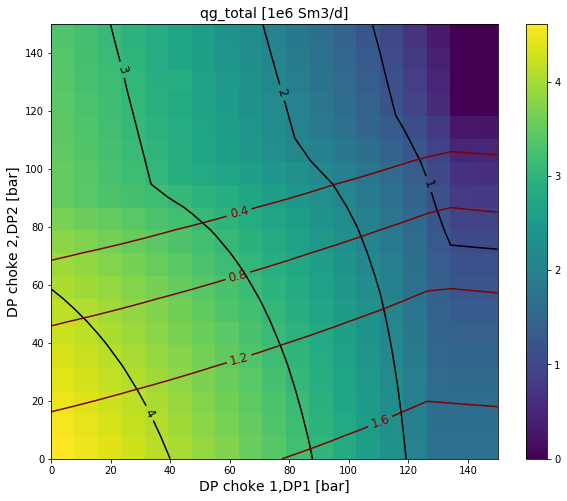

In [93]:
#CREATING COLORMAPS AND CONTOUR PLOTS OF OBJECTIVE VARIABLE  
#AND CONSTRAINED VARIABLE 
obj_opt=2  #1 if revenue, 2 if gas, 3 if condensate
if obj_opt==1:
    obj=revenue
    tag='revenue [1e6 USD]'
elif obj_opt==2:
    obj=qgtotal
    tag='qg_total [1e6 Sm3/d]'
elif obj_opt==3:
    obj=qctotal
    tag='qc_total[Sm3/d]'
const_opt=2 #1 if well 1 gas rate, 2 if gas rate of well 2, 3 if total gas rate
if const_opt==1:
    constr=qg1
elif const_opt==2:
    constr=qg2
elif const_opt==3:
    constr=qgtotal
plt.figure(figsize=(10,8))
#creating mesh of DP1,DP2 to plot
xi,yi=np.mgrid[DP1.min():DP1.max():npoints*1j,DP2.min():DP2.max():npoints*1j]#another option to this is to use X,Y=np.meshgrid(DP1,DP2)
#Contour plot of objective function
contour_obj=plt.contour(xi,yi,obj.reshape(xi.shape),4,colors='black')
plt.clabel(contour_obj, inline=True, fmt='%1.0f',fontsize=12)
#Contour plot of constraint
contour_constr=plt.contour(xi,yi,constr.reshape(xi.shape),4,colors='maroon')
plt.clabel(contour_constr, inline=True, fmt='%1.1f',fontsize=12)
#plot color map of objective function,
plt.pcolormesh(xi,yi,obj.reshape(xi.shape))
#axis labels and plot title
plt.xlabel('DP choke 1,DP1 [bar]',fontsize=14)
plt.ylabel('DP choke 2,DP2 [bar]',fontsize=14)
plt.title(tag,fontsize=14)
plt.colorbar()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power


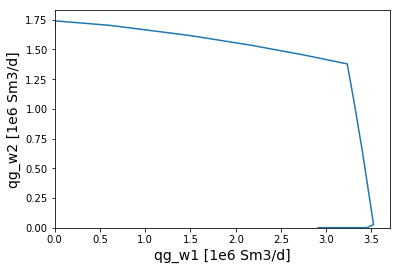

In [94]:
#ESTIMATING FEASIBLE OPERATING REGION, qg1, qg2  
qg1=[]
qg2=[]
dp2=0
DP=np.linspace(250,0,10)
for dp1 in DP:
    x=minimize(error,qg,args=(pR,CR,n,CT,S,Cpl,Cfl,psep,[dp1,dp2]),method='Nelder-Mead') 
    qg1=np.append(qg1,x.x[0])
    qg2=np.append(qg2,x.x[1])
DP=np.linspace(0,250,10)
dp1=0
for dp2 in DP:
    x=minimize(error,qg,args=(pR,CR,n,CT,S,Cpl,Cfl,psep,[dp1,dp2]),method='Nelder-Mead') 
    qg1=np.append(qg1,x.x[0])
    qg2=np.append(qg2,x.x[1])
plt.plot(qg1/1e06,qg2/1e06)
plt.xlabel('qg_w1 [1e6 Sm3/d]',fontsize=14)
plt.ylabel('qg_w2 [1e6 Sm3/d]',fontsize=14)
plt.xlim(0)
plt.ylim(0)
plt.show()